## Optimal Hub determination

## Short Case description

In the underlying case, I aim to introduce a hub at an optimal location based on historical truck delivery routes data. 
For this case, I will only use the destination coordinates of the routes and assume the starting positions of the trucks to be unknown, as the goal of this project is to find a location that is optimal for all destinations. The reason behind that is that Hubs can be used as depots, increase efficiency in transportation through bundling, etc.. In this case, I simply want to assume a central starting point for all outgoing deliveries to the different destinations and try to find the optimal depot location accordingly.

For simplicity, I will work with haversine distances between the different coordinates.

I will first performe clustering on the different nodes in the distribution network and try to identify potential hub locations. 

Based on these potential locations, I will run a Gurobi optimization model that chooses the hub location, which minimizes the sum of all distances travelled for all deliveries in the dataset.

In [52]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns
import pgeocode as pg
import folium
import geopandas as gpd
from folium import plugins
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import gurobipy as gp
from gurobipy import Model, GRB

In [53]:
# import dataset

df = pd.read_excel(r"C:\Users\felix\OneDrive\Dokumente\Python Projects\Optimization Model Gurobi\Delivery truck trip data.xlsx")

df

,GpsProvider,BookingID,Market/Regular,BookingID_Date,vehicle_no,Origin_Location,Destination_Location,Org_lat_lon,Des_lat_lon,Data_Ping_time,...,TRANSPORTATION_DISTANCE_IN_KM,vehicleType,Minimum_kms_to_be_covered_in_a_day,Driver_Name,Driver_MobileNo,customerID,customerNameCode,supplierID,supplierNameCode,Material Shipped
0,CONSENT TRACK,MVCV0000927/082021,Market,2020-08-17 14:59:01.000,KA590408,"TVSLSL-PUZHAL-HUB,CHENNAI,TAMIL NADU","ASHOK LEYLAND PLANT 1- HOSUR,HOSUR,KARNATAKA","13.1550,80.1960","12.7400,77.8200",2020-08-24 00:05:09,...,320.0,NaN,NaN,NaN,NaN,ALLEXCHE45,Ashok leyland limited,VIJEXHOSR7,VIJAY TRANSPORT,BRACKET / GRAB HANDLE
1,VAMOSYS,VCV00014271/082021,Regular,2020-08-27 16:22:22.827,TN30BC5917,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:28,...,103.0,NaN,NaN,RAMESH,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,VJLEXSHE09,VJ LOGISTICS,ZB MODEL PLATE / 3143
2,CONSENT TRACK,VCV00014382/082021,Regular,2020-08-27 17:59:24.987,TN22AR2748,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8710,79.7390","11.8710,79.7390",2020-08-28 09:05:09,...,300.0,NaN,NaN,GIRI,NaN,LUTGCCHE06,Lucas tvs ltd,GSTEXLAK1Q,G.S. TRANSPORT,LETTERING / FUSO
3,VAMOSYS,VCV00014743/082021,Regular,2020-08-28 00:48:24.503,TN28AQ0781,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:31,...,61.0,NaN,NaN,RAVI,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,ARVEXNAM09,ARVINTH TRANSPORT,LU STRUT RA / RADIUS ROD
4,VAMOSYS,VCV00014744/082021,Regular,2020-08-28 01:23:19.243,TN68F1722,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8720,79.6320","11.8720,79.6320",2020-08-28 12:40:29,...,240.0,NaN,NaN,TAMIL,NaN,LUTGCCHE06,Lucas tvs ltd,SRTEXKOR96,SR TRANSPORTS,WISHBONE / V ROD/HDT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6875,JTECH,WDSBKTP42751,Regular,2019-03-27 17:25:33.000,KA219502,"Ramamurthy Nagar, Bangalore, Karnataka","Sahakaranagar P.O, Bangalore, Karnataka","13.007503209603689,77.665098855934886","13.068901840235711,77.590655738806618",2019-06-14 15:20:12,...,12.0,25 FT Open Body 21MT,NaN,NaN,NaN,LTLEXMUM40,Larsen & toubro limited,55556,A S TRANSPORTS,TOOL KIT SET
6876,JTECH,WDSBKTP43203,Regular,2019-03-31 15:02:34.000,KA01AE9163,"Ramamurthy Nagar, Bangalore, Karnataka","Bangalore International Airport, Bangalore, Ka...","13.007503209603689,77.665098855934886","13.196312912801169,77.708156925688726",2019-06-14 15:20:12,...,31.0,40 FT 3XL Trailer 35MT,NaN,NaN,NaN,LTLEXMUM40,Larsen & toubro limited,55556,A S TRANSPORTS,CONTROL LEVER ASSY
6877,JTECH,WDSBKTP43021,Regular,2019-03-29 18:56:26.000,KA01AE9163,"Mugabala, Bangalore Rural, Karnataka","Anekal, Bangalore, Karnataka","16.560192249175344,80.792293091599547","12.722686,77.676518",2019-06-14 15:20:12,...,49.0,40 FT 3XL Trailer 35MT,NaN,NaN,NaN,LTLEXMUM40,Larsen & toubro limited,55556,A S TRANSPORTS,SPARE PARTS AUTOMOBILE
6878,JTECH,WDSBKTP42685,Regular,2019-03-27 08:29:45.000,KA21A3643,"Mugabala, Bangalore Rural, Karnataka","Anekal, Bangalore, Karnataka","16.560192249175344,80.792293091599547","12.896896847817695,77.712223056874862",2019-06-14 15:20:12,...,49.0,40 FT 3XL Trailer 35MT,NaN,NaN,NaN,LTLEXMUM40,Larsen & toubro limited,55556,A S TRANSPORTS,SPARE PARTS AUTOMOBILE


In [54]:
df.columns

Index(['GpsProvider', 'BookingID', 'Market/Regular ', 'BookingID_Date',
       'vehicle_no', 'Origin_Location', 'Destination_Location', 'Org_lat_lon',
       'Des_lat_lon', 'Data_Ping_time', 'Planned_ETA', 'Current_Location',
       'DestinationLocation', 'actual_eta', 'Curr_lat', 'Curr_lon', 'ontime',
       'delay', 'OriginLocation_Code', 'DestinationLocation_Code',
       'trip_start_date', 'trip_end_date', 'TRANSPORTATION_DISTANCE_IN_KM',
       'vehicleType', 'Minimum_kms_to_be_covered_in_a_day', 'Driver_Name',
       'Driver_MobileNo', 'customerID', 'customerNameCode', 'supplierID',
       'supplierNameCode', 'Material Shipped'],
      dtype='object')

In [55]:
df.dtypes

GpsProvider                                   object
BookingID                                     object
Market/Regular                                object
BookingID_Date                        datetime64[ns]
vehicle_no                                    object
Origin_Location                               object
Destination_Location                          object
Org_lat_lon                                   object
Des_lat_lon                                   object
Data_Ping_time                        datetime64[ns]
Planned_ETA                                   object
Current_Location                              object
DestinationLocation                           object
actual_eta                                    object
Curr_lat                                     float64
Curr_lon                                     float64
ontime                                        object
delay                                         object
OriginLocation_Code                           

In [56]:
df[['destination_lat', 'destination_lon']] = df['Des_lat_lon'].str.split(',', n=1, expand=True)


In [57]:
df[['origin_lat', 'origin_lon']] = df['Org_lat_lon'].str.split(',', n=1, expand=True)


In [58]:
df['Org_lat_lon'].nunique()

173

In [59]:
df['Des_lat_lon'].nunique()

522

In [60]:
len(df)

6880

We see that there are only 173 unique origins and 6880 unique destinations of truck routes. This further suggests that there are recurring routes and for simplicity, this could suggest that the carrier may benefit from bundling freights together into one truck in the future. For that, relaxing the time dimension, it could be useful to introduce a hub somewhere in India. This hub could serve as an optional store place that allows to assemble muliple deliveries together and deliver it at ones on a specific route


For this purpose, our goal of this project will be to determine an optimal hub location, that we base on the following assumptions:

- We consider Haversine distances between locations, i.e. do not consider real routes that trucks would take

- We assume that all these deliveries are from one company, that delivers freights from their 173 manufacturers to the customers. In the future, they may make use of the new Hub to facilitate operations and increase efficiency.


In [61]:
df.head()

,GpsProvider,BookingID,Market/Regular,BookingID_Date,vehicle_no,Origin_Location,Destination_Location,Org_lat_lon,Des_lat_lon,Data_Ping_time,...,Driver_MobileNo,customerID,customerNameCode,supplierID,supplierNameCode,Material Shipped,destination_lat,destination_lon,origin_lat,origin_lon
0,CONSENT TRACK,MVCV0000927/082021,Market,2020-08-17 14:59:01.000,KA590408,"TVSLSL-PUZHAL-HUB,CHENNAI,TAMIL NADU","ASHOK LEYLAND PLANT 1- HOSUR,HOSUR,KARNATAKA","13.1550,80.1960","12.7400,77.8200",2020-08-24 00:05:09,...,NaN,ALLEXCHE45,Ashok leyland limited,VIJEXHOSR7,VIJAY TRANSPORT,BRACKET / GRAB HANDLE,12.7400,77.8200,13.1550,80.1960
1,VAMOSYS,VCV00014271/082021,Regular,2020-08-27 16:22:22.827,TN30BC5917,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:28,...,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,VJLEXSHE09,VJ LOGISTICS,ZB MODEL PLATE / 3143,12.8390,79.9540,12.8390,79.9540
2,CONSENT TRACK,VCV00014382/082021,Regular,2020-08-27 17:59:24.987,TN22AR2748,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8710,79.7390","11.8710,79.7390",2020-08-28 09:05:09,...,NaN,LUTGCCHE06,Lucas tvs ltd,GSTEXLAK1Q,G.S. TRANSPORT,LETTERING / FUSO,11.8710,79.7390,11.8710,79.7390
3,VAMOSYS,VCV00014743/082021,Regular,2020-08-28 00:48:24.503,TN28AQ0781,"DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","DAIMLER INDIA COMMERCIAL VEHICLES,KANCHIPURAM,...","12.8390,79.9540","12.8390,79.9540",2020-08-28 12:40:31,...,NaN,DMREXCHEUX,Daimler india commercial vehicles pvt lt,ARVEXNAM09,ARVINTH TRANSPORT,LU STRUT RA / RADIUS ROD,12.8390,79.9540,12.8390,79.9540
4,VAMOSYS,VCV00014744/082021,Regular,2020-08-28 01:23:19.243,TN68F1722,"LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","LUCAS TVS LTD-PONDY,PONDY,PONDICHERRY","11.8720,79.6320","11.8720,79.6320",2020-08-28 12:40:29,...,NaN,LUTGCCHE06,Lucas tvs ltd,SRTEXKOR96,SR TRANSPORTS,WISHBONE / V ROD/HDT,11.8720,79.6320,11.8720,79.6320


In [62]:
# Choose relevant columns for modeling

data = df[['BookingID', 'origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']]

In [63]:
data[['origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']] = round(data[['origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']], 4).astype('float64')

C:\Users\felix\AppData\Local\Temp\ipykernel_9948\3020225103.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[['origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']] = round(data[['origin_lat', 'origin_lon', 'destination_lat', 'destination_lon']], 4).astype('float64')


In [64]:
data

,BookingID,origin_lat,origin_lon,destination_lat,destination_lon
0,MVCV0000927/082021,13.155000,80.196000,12.740000,77.820000
1,VCV00014271/082021,12.839000,79.954000,12.839000,79.954000
2,VCV00014382/082021,11.871000,79.739000,11.871000,79.739000
3,VCV00014743/082021,12.839000,79.954000,12.839000,79.954000
4,VCV00014744/082021,11.872000,79.632000,11.872000,79.632000
...,...,...,...,...,...
6875,WDSBKTP42751,13.007503,77.665099,13.068902,77.590656
6876,WDSBKTP43203,13.007503,77.665099,13.196313,77.708157
6877,WDSBKTP43021,16.560192,80.792293,12.722686,77.676518
6878,WDSBKTP42685,16.560192,80.792293,12.896897,77.712223


In [65]:
# Calculate Distances between origin and destination for each Booking_ID

import math
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    return c * r

# Apply the haversine function to each row
data['Dist_Origin_Dest'] = data.apply(lambda row: haversine(row['origin_lon'], row['origin_lat'], row['destination_lon'], row['destination_lat']), axis=1)

# Display the first few rows of the dataframe
data.head()


C:\Users\felix\AppData\Local\Temp\ipykernel_9948\2027153707.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Dist_Origin_Dest'] = data.apply(lambda row: haversine(row['origin_lon'], row['origin_lat'], row['destination_lon'], row['destination_lat']), axis=1)


,BookingID,origin_lat,origin_lon,destination_lat,destination_lon,Dist_Origin_Dest
0,MVCV0000927/082021,13.155,80.196,12.740,77.820,261.582982
1,VCV00014271/082021,12.839,79.954,12.839,79.954,0.000000
2,VCV00014382/082021,11.871,79.739,11.871,79.739,0.000000
3,VCV00014743/082021,12.839,79.954,12.839,79.954,0.000000
4,VCV00014744/082021,11.872,79.632,11.872,79.632,0.000000


c:\Users\felix\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Dist_Origin_Dest', ylabel='Count'>

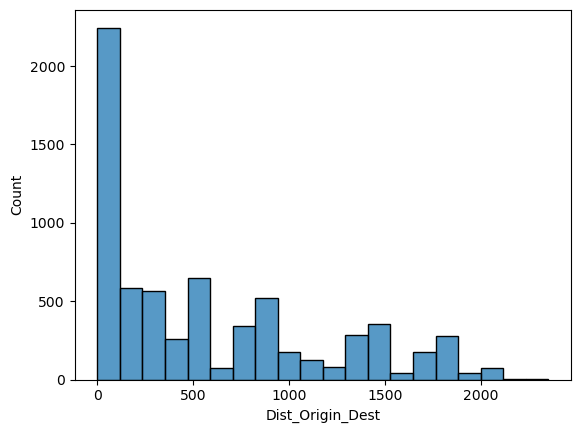

In [66]:
sns.histplot(data=data['Dist_Origin_Dest'], bins= 20)

In [67]:
data['Dist_Origin_Dest'].describe(percentiles=[.25,.50,.75])

count    6880.000000
mean      579.683261
std       591.085989
min         0.000000
25%        35.881408
50%       384.815538
75%       922.473022
max      2349.085481
Name: Dist_Origin_Dest, dtype: float64

This distribution of direct distances suggests that many of the routes would probably not need a hub in between, assuming that a truck can easily drive 500-800 km in one day.

Let's now check how the dots are distributed on the map.

In [18]:
# Initialize the map
#map = folium.Map(location=[20.5937, 78.9629], zoom_start=30)

# Add manufacturers to the map as red markers
#for index, row in data.iterrows():
#    folium.Marker(location=[row['origin_lat'], row['origin_lon']], icon=folium.Icon(color='red')).add_to(map)

# Add customers to the map as blue markers
#for index, row in data.iterrows():
 #   folium.Marker(location=[row['destination_lat'], row['destination_lon']], icon=folium.Icon(color='blue')).add_to(map)

# Display the map
#map


SyntaxError: incomplete input (3809918885.py, line 1)

In [ ]:
from folium.plugins import HeatMap

# Assuming df is your DataFrame containing the data
manufacturers = data[['origin_lat', 'origin_lon']].drop_duplicates()
customers = data[['destination_lat', 'destination_lon']].drop_duplicates()

# Initialize the map with a location near India and an appropriate zoom level
mymap = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

# Convert the manufacturer and customer locations to list of lists
manufacturers_list = manufacturers[['origin_lat', 'origin_lon']].values.tolist()
customers_list = customers[['destination_lat', 'destination_lon']].values.tolist()

# Create HeatMap layers for manufacturers and customers with different color schemes
heat_map_manufacturers = HeatMap(manufacturers_list, radius=15, blur=20, max_zoom=13, gradient={0.4: 'blue', 0.6: 'cyan', 1: 'lime'})
heat_map_customers = HeatMap(customers_list, radius=15, blur=20, max_zoom=13, gradient={0.4: 'red', 0.6: 'orange', 1: 'yellow'})

# Add the HeatMap layers to the map
mymap.add_child(heat_map_manufacturers)
mymap.add_child(heat_map_customers)

# Display the map
mymap

### Clustering: Find potential hubs

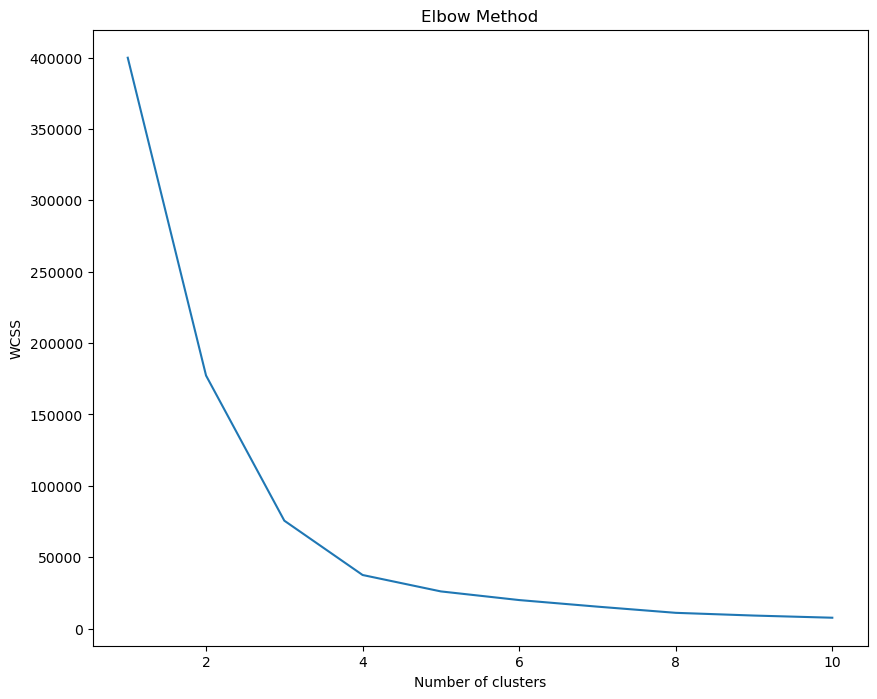

In [116]:
# Feature selection
X = data[['destination_lon', 'destination_lat']]

# Calculate WCSS (Within-Cluster-Sum-of-Squares)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph to observe 'The elbow'
plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()


In [117]:
# Initializing KMeans with 4 clusters
kmeans = KMeans(n_clusters=4) 

kmeans.fit(X)

# Predicting the cluster labels and fitting them in to the same dataframe
data['cluster_label_k4'] = kmeans.predict(X)

# Finding the centroid or mean location for each cluster, which can be considered as a potential location for a new hub.
centroid_locations_K_4 = data.groupby('cluster_label_k4')[['destination_lat', 'destination_lon']].mean().reset_index()

print(centroid_locations_K_4)

c:\Users\felix\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   cluster_label_k4  destination_lat  destination_lon
0                 0        13.393923        78.760509
1                 1        23.599392        87.313476
2                 2        28.592571        77.025476
3                 3        21.115431        73.022556


C:\Users\felix\AppData\Local\Temp\ipykernel_9948\3572087782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster_label_k4'] = kmeans.predict(X)


In [118]:
centroid_locations_K_4 = centroid_locations_K_4.rename(columns={'cluster_label_k4':'cluster_label', 'destination_lat': 'hub_lat', 'destination_lon': 'hub_lon'})

centroid_locations_K_4

,cluster_label,hub_lat,hub_lon
0,0,13.393923,78.760509
1,1,23.599392,87.313476
2,2,28.592571,77.025476
3,3,21.115431,73.022556


In [119]:
# Counting the number of customers in each cluster
cluster_counts_4 = data.groupby('cluster_label_k4').size()

print(cluster_counts_4)
print(cluster_counts_4.sum())
len(data)

cluster_label_k4
0    3612
1    1135
2    1098
3    1035
dtype: int64
6880


6880

In [120]:
# Initializing KMeans with 4 clusters
kmeans = KMeans(n_clusters=3) 

kmeans.fit(X)

# Predicting the cluster labels and fitting them in to the same dataframe
data['cluster_label_k3'] = kmeans.predict(X)

# Finding the centroid or mean location for each cluster, which can be considered as a potential location for a new hub.
centroid_locations_K_3 = data.groupby('cluster_label_k3')[['destination_lat', 'destination_lon']].mean().reset_index()

print(centroid_locations_K_3)

c:\Users\felix\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   cluster_label_k3  destination_lat  destination_lon
0                 0        25.029646        75.072267
1                 1        13.420976        78.738095
2                 2        23.610512        87.294323


C:\Users\felix\AppData\Local\Temp\ipykernel_9948\650691734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster_label_k3'] = kmeans.predict(X)


In [121]:
centroid_locations_K_3 = centroid_locations_K_3.rename(columns={'cluster_label_k3':'cluster_label', 'destination_lat': 'hub_lat', 'destination_lon': 'hub_lon'})

centroid_locations_K_3

,cluster_label,hub_lat,hub_lon
0,0,25.029646,75.072267
1,1,13.420976,78.738095
2,2,23.610512,87.294323


In [122]:
potential_hubs_k4 = centroid_locations_K_4[['hub_lat', 'hub_lon']]
potential_hubs_k3 = centroid_locations_K_3[['hub_lat', 'hub_lon']]


# Initialize the map with a location near India and an appropriate zoom level
hub_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

for index, row in potential_hubs_k4.iterrows():
    folium.Marker(location=[row['hub_lat'], row['hub_lon']], icon=folium.Icon(color='red')).add_to(hub_map)

for index, row in potential_hubs_k3.iterrows():
    folium.Marker(location=[row['hub_lat'], row['hub_lon']], icon=folium.Icon(color='blue')).add_to(hub_map) 

# Display the map
hub_map

In [123]:
potential_hubs = pd.concat([centroid_locations_K_3,centroid_locations_K_4], 
                   ignore_index=True)

potential_hubs["cluster_label"] = potential_hubs.index

potential_hubs

,cluster_label,hub_lat,hub_lon
0,0,25.029646,75.072267
1,1,13.420976,78.738095
2,2,23.610512,87.294323
3,3,13.393923,78.760509
4,4,23.599392,87.313476
5,5,28.592571,77.025476
6,6,21.115431,73.022556


Due to high geographical overlap of cluster centroid pairs 1,3 and 2,4, I will drop cluster centroids 3 and 4 from the list of potential hubs

In [124]:
potential_hubs = potential_hubs.drop([3,4])

potential_hubs = potential_hubs.reset_index()

potential_hubs

,index,cluster_label,hub_lat,hub_lon
0,0,0,25.029646,75.072267
1,1,1,13.420976,78.738095
2,2,2,23.610512,87.294323
3,5,5,28.592571,77.025476
4,6,6,21.115431,73.022556


In [125]:
# Initialize the map with a location near India and an appropriate zoom level
final_hub_map = folium.Map(location=[20.5937, 78.9629], zoom_start=5)

for index, row in potential_hubs.iterrows():
    folium.Marker(location=[row['hub_lat'], row['hub_lon']], icon=folium.Icon(color='red')).add_to(final_hub_map)

# Display the map
final_hub_map

Now, create dictionaries to calculate partial routes from origin to hub and hub to destination (for each hub)

In [128]:
dist_man_hub_with_booking_id = {}
dist_hub_dest_with_booking_id = {}

# Iterate over each new potential hub
for _, hub_row in potential_hubs.iterrows():
    cluster_label = hub_row['cluster_label']
    hub_lat = hub_row['hub_lat']
    hub_lon = hub_row['hub_lon']

    # Add distances to/from the new hub to the existing dictionaries
    for index, row in data.iterrows():
        # Retrieve manufacturer's and customer's coordinates for each row
        origin_lon = row['origin_lon']
        origin_lat = row['origin_lat']
        dest_lon = row['destination_lon']
        dest_lat = row['destination_lat']

        # Calculate distances
        dist_man_hub_with_booking_id[(row['BookingID'], origin_lon, origin_lat, cluster_label)] = haversine(origin_lon, origin_lat, hub_lon, hub_lat)
        dist_hub_dest_with_booking_id[(row['BookingID'], cluster_label, dest_lon, dest_lat)] = haversine(hub_lon, hub_lat, dest_lon, dest_lat)


In [129]:
# check dictionaries
dist_hub_dest_with_booking_id

{('MVCV0000927/082021', 0.0, 77.82, 12.74): 1396.6334968381304,
 ('VCV00014271/082021', 0.0, 79.954, 12.839): 1449.0520783586526,
 ('VCV00014382/082021', 0.0, 79.739, 11.871): 1543.2911272053675,
 ('VCV00014743/082021', 0.0, 79.954, 12.839): 1449.0520783586526,
 ('VCV00014744/082021', 0.0, 79.632, 11.872): 1539.6437432190528,
 ('VCV00014749/082021', 0.0, 79.954, 12.839): 1449.0520783586526,
 ('VCV00014750/082021', 0.0, 79.954, 12.839): 1449.0520783586526,
 ('VCV00014812/082021', 0.0, 79.954, 12.839): 1449.0520783586526,
 ('MVCV0001769/082021', 0.0, 77.786, 12.766): 1393.0672274841718,
 ('VCV00014665/082021', 0.0, 79.954, 12.839): 1449.0520783586526,
 ('VCV00014745/082021', 0.0, 79.954, 12.839): 1449.0520783586526,
 ('VCV00014866/082021', 0.0, 80.196, 13.155): 1425.444337411125,
 ('VCV00014879/082021', 0.0, 79.954, 12.839): 1449.0520783586526,
 ('VCV00014872/082021', 0.0, 79.954, 12.839): 1449.0520783586526,
 ('VCV00014554/082021', 0.0, 79.954, 12.839): 1449.0520783586526,
 ('VCV0001457

# Gurobi Model

In [138]:
hubs = ['0.0', '1.0', '2.0', '5.0', '6.0']

# Initialize the model
model = Model('LogisticsOptimization')

# Decision Variables
X_ih = model.addVars(dist_man_hub_with_booking_id.keys(), vtype=GRB.BINARY, name="X_ih")
X_hk = model.addVars(dist_hub_dest_with_booking_id.keys(), vtype=GRB.BINARY, name="X_hk")
Y_h = model.addVars(hubs, vtype=GRB.BINARY, name="Y_h")

# Objective Function
model.setObjective(
    sum(dist_man_hub_with_booking_id[i] * X_ih[i] for i in dist_man_hub_with_booking_id) +
    sum(dist_hub_dest_with_booking_id[k] * X_hk[k] for k in dist_hub_dest_with_booking_id),
    GRB.MINIMIZE
)


# Constraints
# Ensure each manufacturer is connected to the hub
for i, k, h, j in dist_man_hub_with_booking_id.keys():
    model.addConstr(sum(X_ih[i, k, h, j] for j in hubs) == 1)

# Ensure each customer region is connected to exactly one hub
for i, j, k, h in dist_hub_dest_with_booking_id.keys():
    model.addConstr(sum(X_hk[i, j, k, h] for j in hubs) == 1)



# Optimize the model
model.optimize()

KeyError: ('MVCV0000927/082021', 80.196, 13.155, '0.0')